# Demographics for alcoholic beverage entitlements

Let's take a close look at PCTS entitlements for serving of alcoholic beverages (CUB suffix)

In [1]:
import geopandas
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas
import sklearn.ensemble
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.utils

import laplan

cat = intake.open_catalog("../catalogs/*.yml")

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


## Prepping the data

First, download a bunch of relevant data into dataframes:

In [2]:
# Census tracts
tracts = cat.census_tracts.read()
# Parcels
parcels = cat.parcels_with_duplicates.read()
parcels = parcels.set_geometry(parcels.geometry.centroid)
# Conversion from parcels to tracts
parcel_to_tract = cat.crosswalk_parcels_tracts.read()
# Zoning
zoning = cat.zoning.read().set_crs(epsg=2229, allow_override=True)

We presume that CUB permits should only be in areas zoned for commercial use. Let's find all the parcels that fall within a commercial zoning area:

In [3]:
commercial_zoning = zoning[zoning.ZONE_SMRY == "COMMERCIAL"]

commercial_parcels = geopandas.sjoin(
    parcels,
    commercial_zoning,
    how="inner",
    op="intersects",
)

As an aggregate statistic, count the number of commercial parcels
on a per-census-tract level:

In [4]:
parcels_per_tract = (
    commercial_parcels
    .drop_duplicates(subset=["x","y"])
    .merge(parcel_to_tract[["AIN", "GEOID"]], on="AIN", how="left")
    .groupby("GEOID")
    .size()
)

Now, let's bring in Census data:

In [5]:
census = cat.census_analysis_table.read()

And PCTS CUB cases:

In [6]:
pcts = cat.pcts2.read()
pcts = laplan.pcts.subset_pcts(pcts, get_dummies=True, suffix_list=["CUB"], verbose=True)
pcts = laplan.pcts.drop_child_cases(pcts, keep_child_entitlements=True)

Parsing PCTS case numbers
2146 cases failed to parse.
Getting dummy indicators for case types
Prefixes with no associated cases:  {'HPO', 'DIR', 'APCW', 'APCH', 'ADM', 'CHC', 'APCC', 'TT', 'APCS', 'ENV', 'CPC', 'APCSV', 'PS', 'VTT', 'APCE', 'APCNV', 'AA'}


Associate each case with a census tract:

In [7]:
pcts = pcts.merge(
    parcel_to_tract[["GEOID", "AIN"]],
    how="left",
    on="AIN",
)

Count the number of CUB cases per census tract:

In [8]:
cub_count = pcts[[
    "GEOID",
    "CUB",
]].groupby("GEOID").size()

In [9]:
joined = (
    census
    .set_index("GEOID")
    .assign(
        n_commercial_parcels=parcels_per_tract,
        n_cub=cub_count,
    )
    .fillna({"n_commercial_parcels": 0, "n_cub": 0})
)

In [10]:
joined = geopandas.GeoDataFrame(joined, geometry=tracts.set_index("GEOID10").geometry)

## Where is commercial zoning?

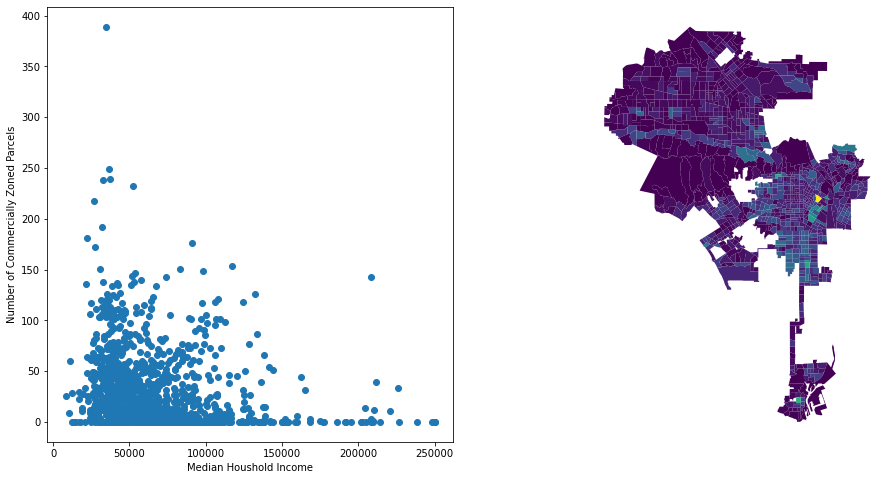

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].scatter(joined.medhhincome, joined.n_commercial_parcels)
ax[0].set_xlabel("Median Houshold Income")
ax[0].set_ylabel("Number of Commercially Zoned Parcels")
ax[1].set_xlabel("Number of Commercially Zoned Parcels")
ax[1].axis("off")
joined.plot(ax=ax[1], column="n_commercial_parcels")

## Modeling CUB entitlements

Let's use a Random Forest regressor as a baseline model for relating CUB permits to
demographic and zoning data. These models tend to do very well at fitting data and are simple to create.

In [12]:
variables = [
    "medhhincome",
    "pct_pop_renter",
    "pct_zero_veh_workers",
    "density",
    "pct_whitenonhisp",
    "n_commercial_parcels",
]
target = "n_cub"

to_fit = joined.dropna()[variables + [target, "geometry"]]

Let's visualize the spatial distribution of these variables to check that they make sense:

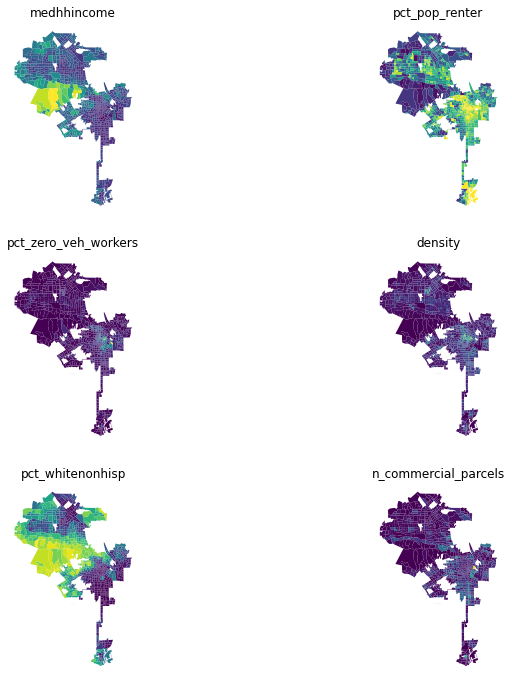

In [13]:
fig, axes = plt.subplots(3, 2, figsize=(12,12))
for i, var in enumerate(variables):
    ax = axes.ravel()[i]
    to_fit.plot(ax=ax, column=var)
    ax.axis("off")
    ax.set_title(var)

In [14]:
# Set a max depth to avoid over-fitting
random_forest_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.ensemble.RandomForestRegressor(max_depth=8)),
])

In [15]:
random_forest_model.fit(to_fit[variables], to_fit[target])

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', RandomForestRegressor(max_depth=8))])

In [16]:
def plot_model(predictions):
    vmin=0
    vmax=50
    fig, axes = plt.subplots(1,2, figsize=(16, 8))
    axes[0].axis("off")
    axes[0].set_title("Actual Number of CUB")
    to_fit.plot(ax=axes[0],column=to_fit.n_cub, vmax=vmax, vmin=vmin)
    axes[1].axis("off")
    axes[1].set_title("Predicted number of CUB")
    to_fit.plot(ax=axes[1],column=predictions, vmax=vmax, vmin=vmin)
    plt.close(fig)
    return fig

Plot up the model to see how it does:

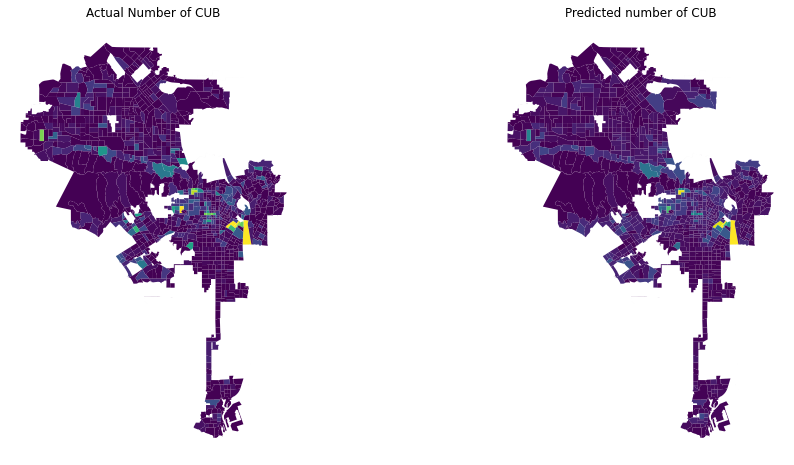

In [17]:
plot_model(random_forest_model.predict(to_fit[variables]))

Which of the features we have chosen are the most important in the random forest?

In [18]:
pandas.Series(random_forest_model["regressor"].feature_importances_, index=variables)

medhhincome             0.130704
pct_pop_renter          0.133274
pct_zero_veh_workers    0.091888
density                 0.161808
pct_whitenonhisp        0.156705
n_commercial_parcels    0.325621
dtype: float64

Of our variables, the percentage of renters and the percentage of zero vehicle workers have the least explanatory power.
Let's drop them and see how the model performs.

In [19]:
fewer_variables= [
    "medhhincome",
    "density",
    "pct_whitenonhisp",
    "n_commercial_parcels",
]
target = "n_cub"

random_forest_model.fit(to_fit[fewer_variables], to_fit[target])
pandas.Series(random_forest_model["regressor"].feature_importances_, index=fewer_variables)

medhhincome             0.181356
density                 0.232185
pct_whitenonhisp        0.223322
n_commercial_parcels    0.363138
dtype: float64

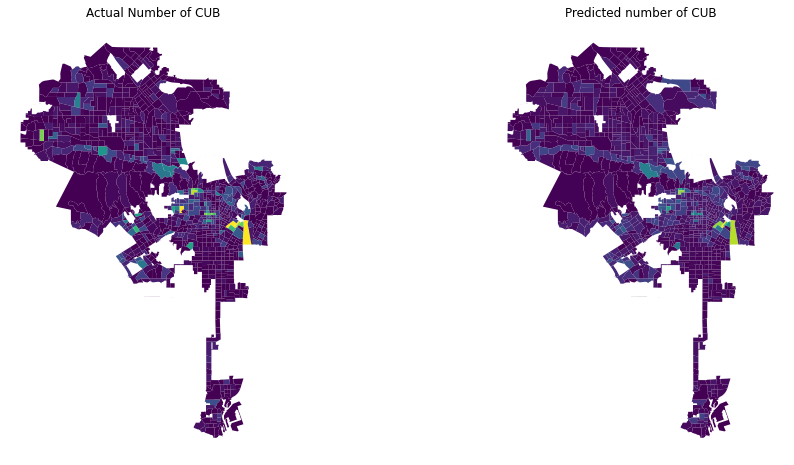

In [20]:
plot_model(random_forest_model.predict(to_fit[fewer_variables]))

Looks like it still does an acceptable job of predicing where the entitlements will be.
Unfortunately, random forest regression has a major drawback: it is difficult to interpret.
There is not a strong meaning we can attach to the decision tree splits,
and due to its ensemble nature, it is difficult to visualize.

We can instead try to fit the same data to a model with a strong backing process:
Poisson linear regression. In this model, the number of CUB entitlements are
modeled as a Poisson process, where the underlying rate is a log-linear function
of our features.


In [21]:
poisson_model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.linear_model.PoissonRegressor(fit_intercept=True, tol=1.e-6))
])

In [22]:
np.random.seed(1)

def sample_poisson_model(data, target, norm=1): 
    def get_coefs(model):
        return model["regressor"].coef_
    
    samples = np.array([
        get_coefs(
            poisson_model.fit(
                *sklearn.utils.resample(
                    data,
                    (target/norm).replace([np.nan, np.inf], 0.0),
                )
            )
        )
        for i in range(1000)
    ])
    return samples

In [23]:
samples = sample_poisson_model(to_fit[fewer_variables], to_fit[target])

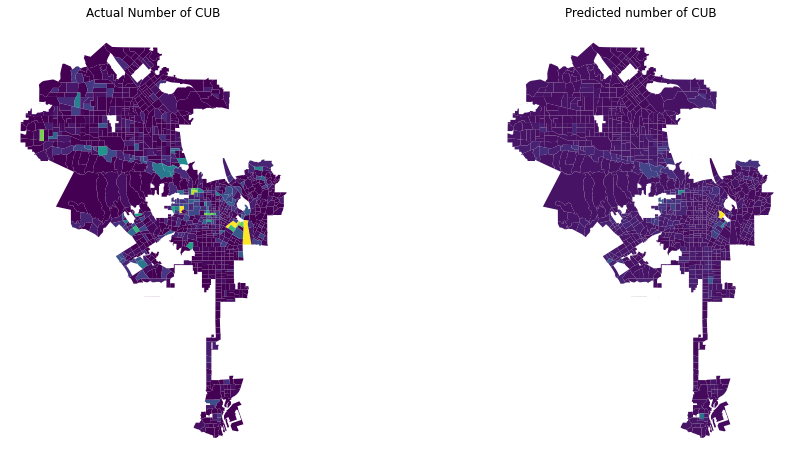

In [24]:
poisson_model.fit(to_fit[fewer_variables], to_fit[target])
plot_model(poisson_model.predict(to_fit[fewer_variables]))

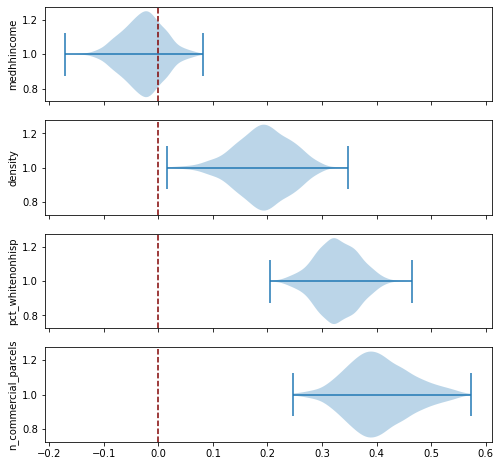

In [25]:
fig, axes = plt.subplots(
    len(fewer_variables),
    1,
    sharex=True,
    sharey=True,
    figsize=(8,8),

)

for i, var in enumerate(fewer_variables):
    ax = axes[i]
    ax.violinplot(samples[:,i], vert=False)
    ax.set_ylabel(var)
    ax.axvline(0, color="maroon", ls="--")

#### Interpreting the coefficients

In [26]:
scaler = poisson_model["scaler"]
regressor = poisson_model["regressor"]

In [27]:
beta = pandas.Series(regressor.coef_/scaler.scale_, index=fewer_variables)
alpha = regressor.intercept_ - np.dot(scaler.mean_ , beta)

In [28]:
import IPython.display

In [29]:
scale = 10000
val = (np.exp(beta[0]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every ${scale:,} increase in median household income, "
    f"there is a {val:.1f}% decrease in CUB entitlements"
))
scale = 1000
val = (np.exp(beta[1]*scale)-1.0)*100.
display(IPython.display.Markdown(
    f"For every {scale:,} people/km increase in population density, "
    f"there is a {val:.1f}% increase in CUB entitlements"
))
scale = 0.1
val = (np.exp(beta[2]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {100*scale:g}% increase in population of white non-Hispanic residents, "
    f"there is a {val:.1f}% increase in CUB entitlements"
))
scale = 10
val = (np.exp(beta[3]*scale)-1)*100.
display(IPython.display.Markdown(
    f"For every {scale:g} additional commercially zones parcels, "
    f"there is a {val:.1f}% increase in CUB entitlements"
))

For every $10,000 increase in median household income, there is a -0.8% decrease in CUB entitlements

For every 1,000 people/km increase in population density, there is a 1.5% increase in CUB entitlements

For every 10% increase in population of white non-Hispanic residents, there is a 13.1% increase in CUB entitlements

For every 10 additional commercially zones parcels, there is a 10.5% increase in CUB entitlements